# 1.- Exploratory Data Analysis

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel", font="sans-serif")
sns.set_context("notebook", font_scale=0.8)

# Display options for Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.3f}')

In [ ]:
# Load your dataset
df = pd.read_csv("../data/bike_sales_data.csv", index_col="Week")
df.index = pd.to_datetime(df.index, format='mixed')


In [3]:
# Basic data overview
print("Shape of the dataset:", df.shape)

print("Summary of numerical features:")
print(df.describe())

print("Data types and null counts:")
print(df.info())

print("Check for missing values:")
print(df.isnull().sum())

print("First five rows of the dataset:")
df.head()

Shape of the dataset: (260, 8)
Summary of numerical features:
           sales  branded_search_spend  nonbranded_search_spend  \
count    260.000               260.000                  260.000   
mean   68107.554              2033.680                  402.384   
std    19608.831               902.962                  200.050   
min    29088.000              1375.920                  229.320   
25%    54405.000              1556.100                  238.680   
50%    64442.070              1606.800                  351.000   
75%    83872.112              1928.160                  478.378   
max   113762.880              7800.000                 1093.693   

       facebook_spend  print_spend  ooh_spend  tv_spend  radio_spend  
count         260.000      260.000    260.000   260.000      260.000  
mean         1015.263      376.923    188.462   278.846      523.077  
std           453.045      487.534    391.835   788.512     1033.907  
min           660.231        0.000      0.000     

,sales,branded_search_spend,nonbranded_search_spend,facebook_spend,print_spend,ooh_spend,tv_spend,radio_spend
Week,,,,,,,,
2017-07-23,58850.000,1528.800,463.320,802.620,0,0,0,0
2017-07-30,62050.000,1575.600,468.000,819.312,0,0,0,0
2017-08-06,59388.000,1544.400,477.360,749.034,0,0,0,0
2017-08-13,56964.000,1528.800,468.000,741.468,0,0,0,0
2017-08-20,53460.000,1560.000,458.640,811.200,0,0,0,0


## Correlation Heatmap

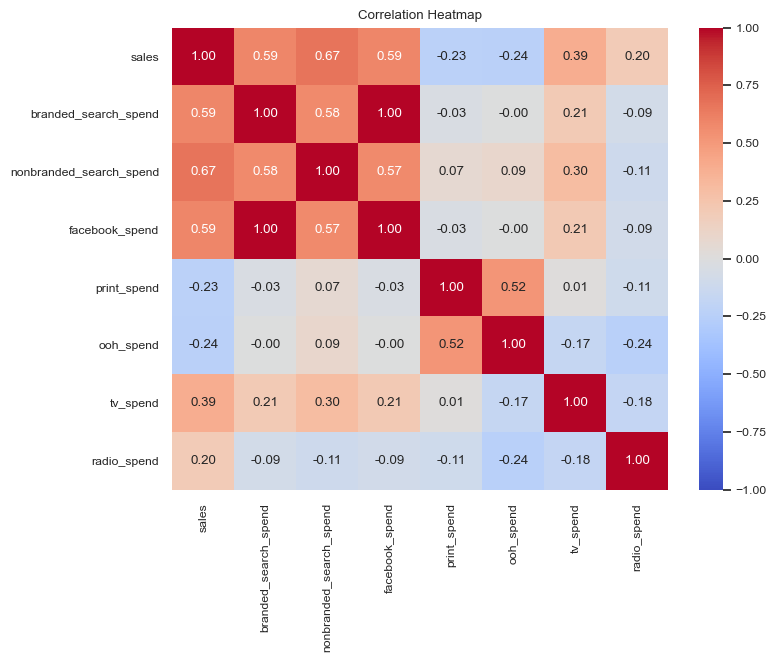

In [4]:
# Correlation heatmap for numerical features
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

## Pairplot

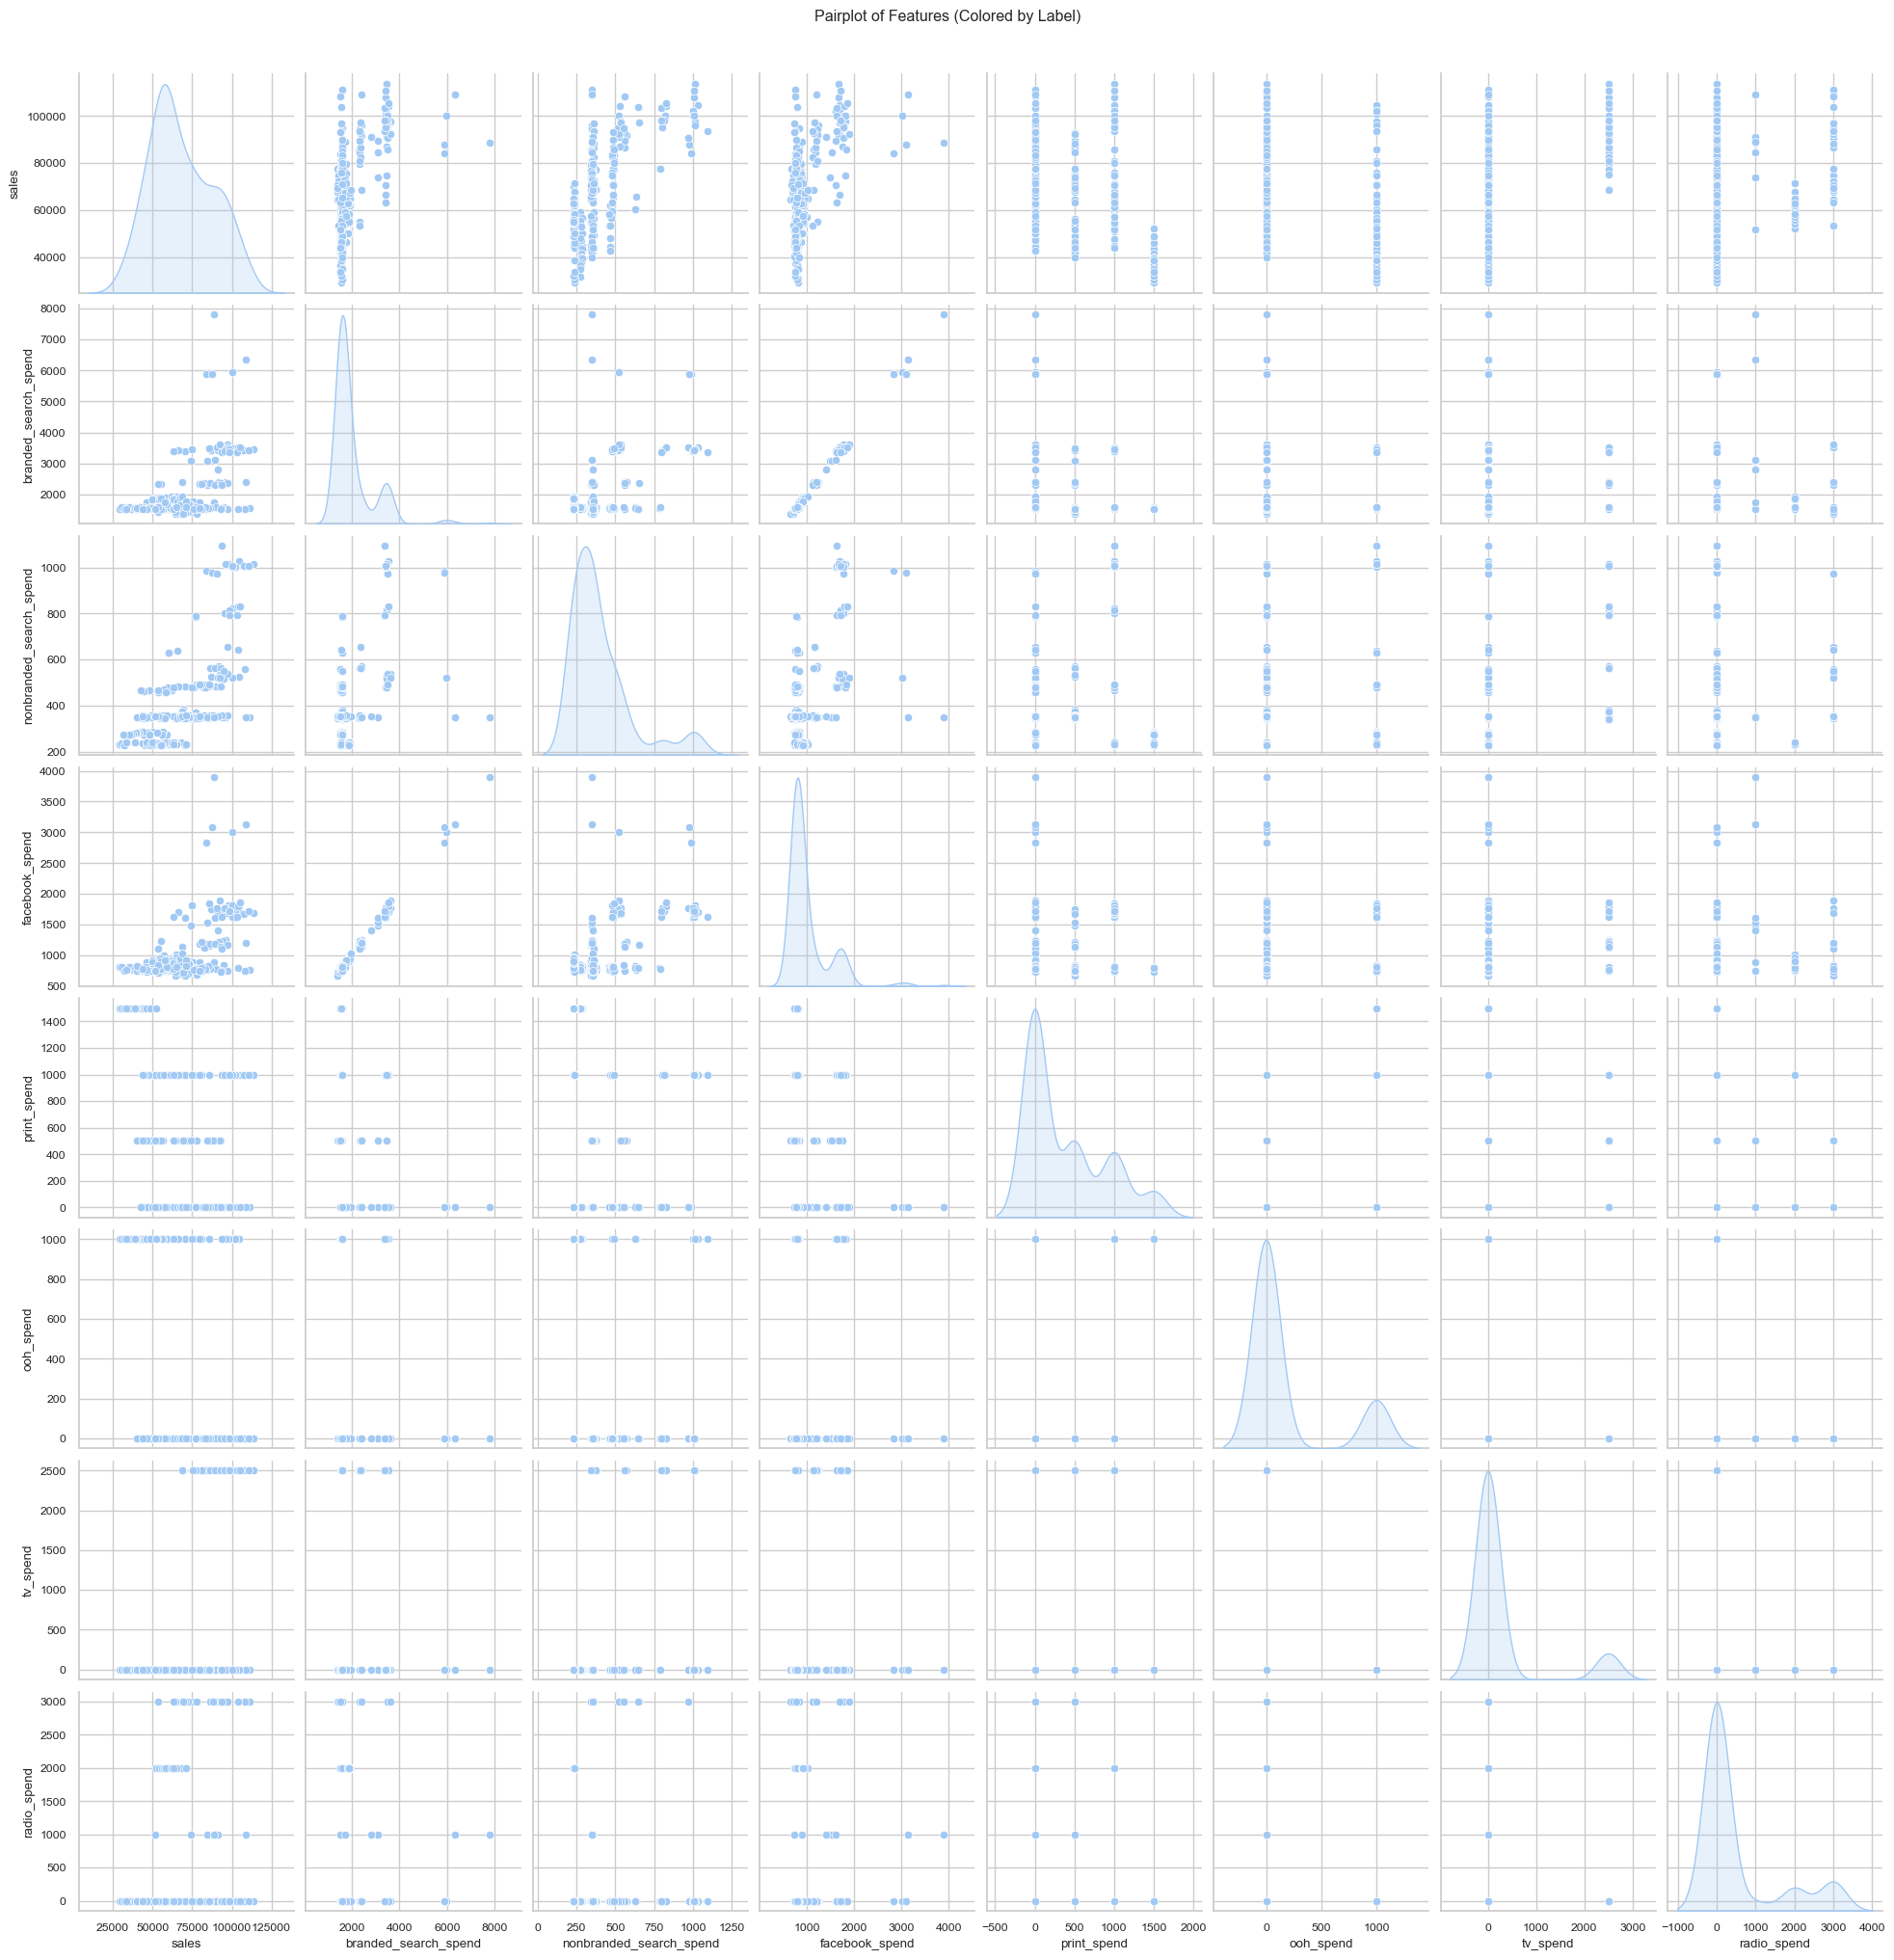

In [5]:
num_columns = ['branded_search_spend', 'nonbranded_search_spend',
               'facebook_spend', 'print_spend', 'ooh_spend', 'tv_spend',
               'radio_spend']
# Pairplot to visualize relationships and distributions
g = sns.pairplot(df, vars=df.columns, diag_kind='kde')
# g.map_upper(sns.kdeplot, n_levels=30)
plt.suptitle("Pairplot of Features (Colored by Label)", y=1.02)
plt.show()

## Outlier Detection

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to detect outliers using IQR
def detect_outliers(df):
    outliers = {}
    all_outlier_indices = {}

    for feature in df.select_dtypes(include=['float64', 'int64']).columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        feature_outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        outliers[feature] = feature_outliers

        # Convert datetime index to integers for processing
        all_outlier_indices[feature] = sorted(df.index.get_indexer(feature_outliers.index))

    return outliers, all_outlier_indices

# Detect outliers in dataset
outliers, outlier_indices = detect_outliers(df)

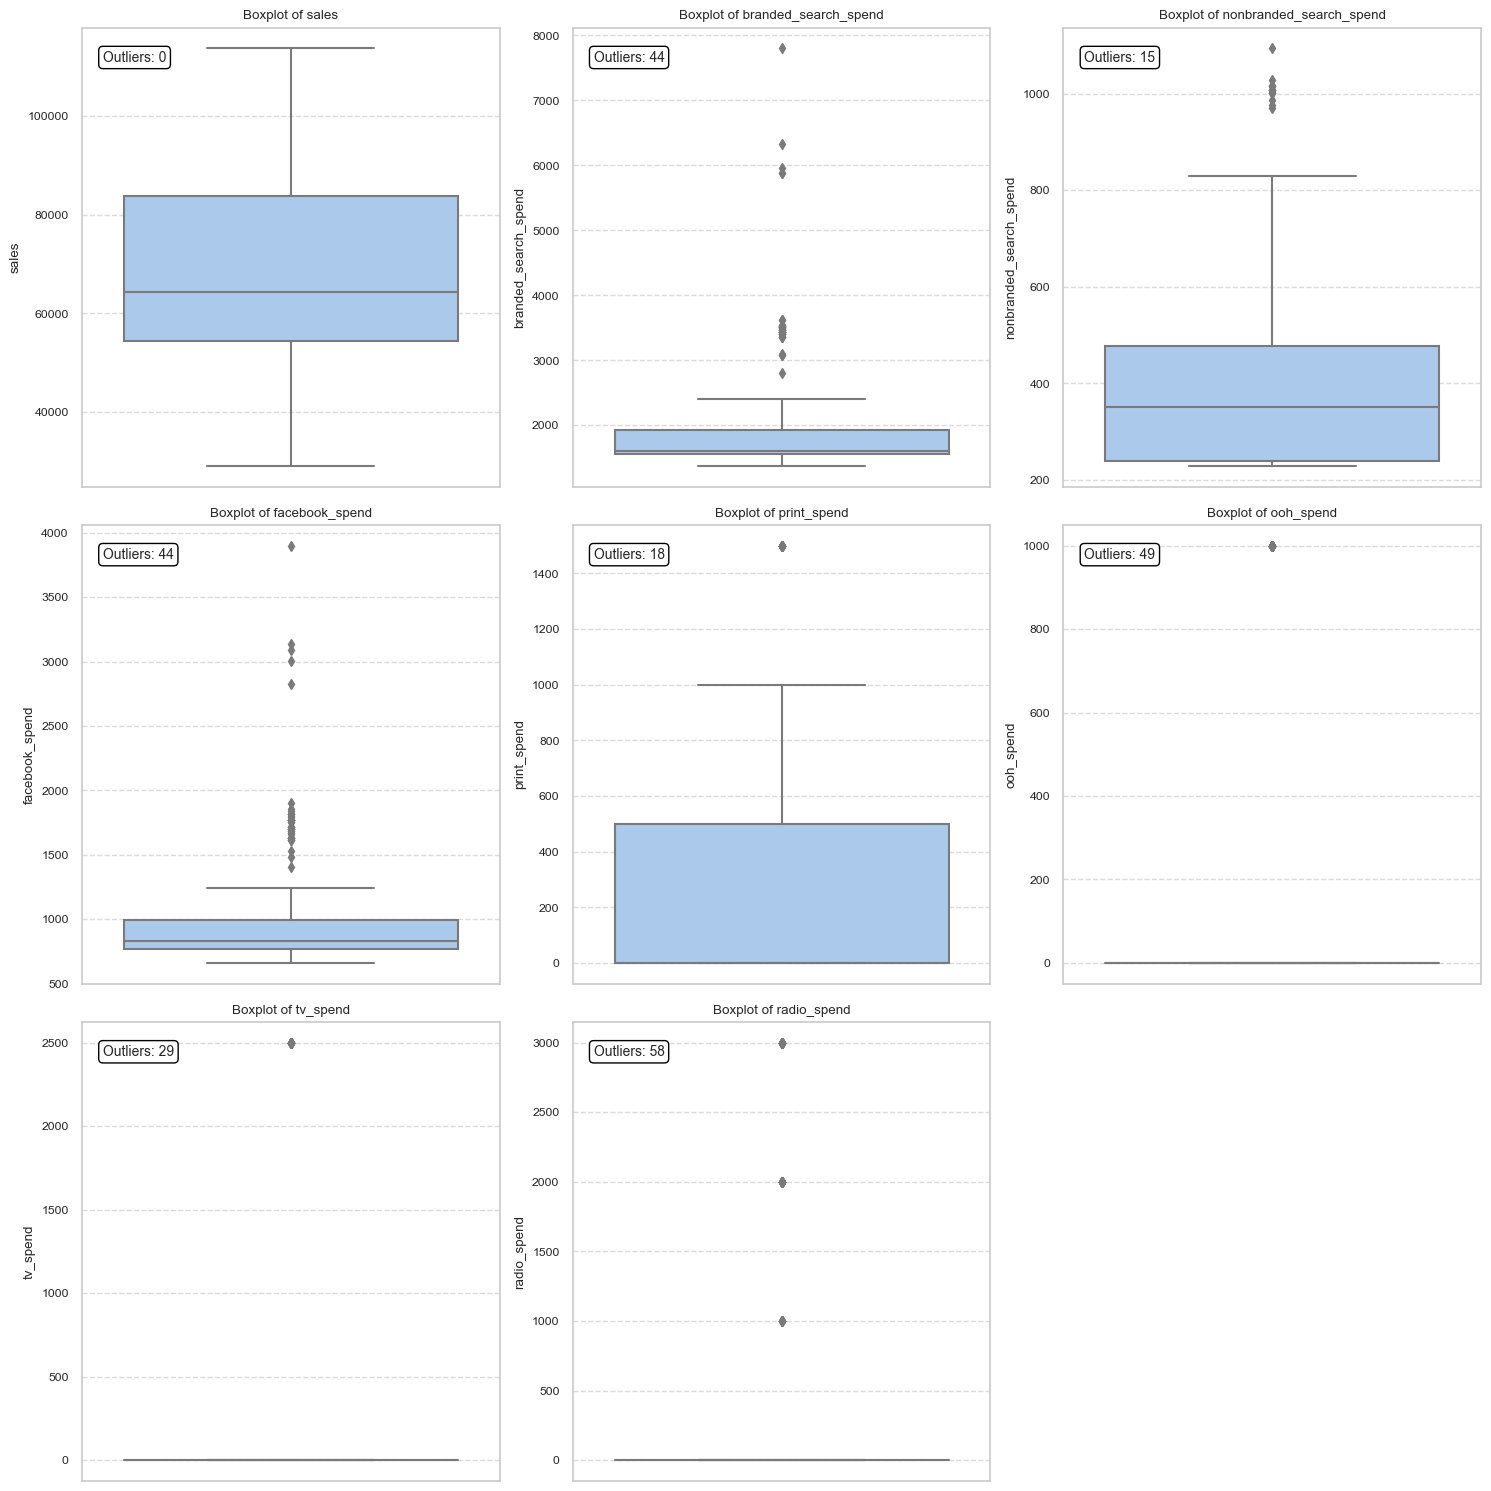

In [7]:
# Get numerical columns
num_features = df.select_dtypes(include=['float64', 'int64']).columns

# Define grid layout (3 columns per row)
num_cols = 3
num_rows = -(-len(num_features) // num_cols)  # Compute needed rows

# Create figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))
axes = axes.flatten()  # Flatten axes array for easier iteration

# Plot boxplots in grid format
for i, feature in enumerate(num_features):
    sns.boxplot(y=df[feature], ax=axes[i], palette="pastel")
    axes[i].set_title(f"Boxplot of {feature}")
    axes[i].set_ylabel(feature)
    axes[i].grid(axis='y', linestyle='--', alpha=0.7)

    # Count number of outliers
    num_outliers = len(outliers[feature])

    # Add text with the number of outliers in the top-left corner
    axes[i].text(0.05, 0.95, f"Outliers: {num_outliers}", 
                 transform=axes[i].transAxes, fontsize=10, 
                 verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()



In [8]:
# Function to group consecutive integer indices
def group_consecutive_outliers(indices):
    if not indices:
        return []

    grouped_ranges = []
    start = indices[0]
    prev = indices[0]

    for i in range(1, len(indices)):
        if indices[i] != prev + 1:  # If there's a break, save the previous range
            grouped_ranges.append((start, prev))
            start = indices[i]
        prev = indices[i]

    grouped_ranges.append((start, prev))  # Save the last range
    return grouped_ranges

# Function to plot KPI and channels with continuous outlier bands
def channels_kpi_relation_plotting(df, outliers, outlier_indices):
    
    # Convert datetime index to integers for calculations
    int_to_date = dict(enumerate(df.index))  # Mapping of integers to dates

    # Create a figure with more vertical space
    fig = make_subplots(rows=2, cols=1, shared_xaxes=True, 
                        vertical_spacing=0.2,
                        row_heights=[0.4, 0.6],
                        subplot_titles=("Sales (KPI)", "Advertising Channels"))

    # Define color palette and symbols
    colors = ['blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan']
    markers = ['circle', 'square', 'diamond', 'cross', 'x', 'star', 'triangle-up', 'triangle-down']

    # =====================  KPI (Sales) PLOT =====================
    fig.add_trace(go.Scatter(
        x=df.index, y=df['sales'],
        mode='lines+markers', name='Sales',
        line=dict(color='red', width=1),
        marker=dict(symbol='circle', size=4, color='red')  
    ), row=1, col=1)

    # Draw **continuous bands** for outliers in Sales
    for start_idx, end_idx in group_consecutive_outliers(outlier_indices.get('sales', [])):
        fig.add_shape(
            type="rect",
            x0=int_to_date[start_idx], x1=int_to_date[end_idx],  # Map back to datetime
            y0=df['sales'].min(), y1=df['sales'].max(),
            fillcolor='red', opacity=0.2, line_width=0, row=1, col=1
        )

    # =====================  ADVERTISING CHANNELS PLOT =====================
    for i, feature in enumerate(df.drop('sales', axis=1).columns):
        fig.add_trace(go.Scatter(
            x=df.index, y=df[feature],
            mode='lines+markers', name=feature,
            line=dict(color=colors[i % len(colors)], width=1),
            marker=dict(symbol=markers[i % len(markers)], size=4, color=colors[i % len(colors)])  
        ), row=2, col=1)

        # Draw **continuous bands** for outliers in each channel
        for start_idx, end_idx in group_consecutive_outliers(outlier_indices.get(feature, [])):
            fig.add_shape(
                type="rect",
                x0=int_to_date[start_idx], x1=int_to_date[end_idx],  # Map back to datetime
                y0=df[feature].min(), y1=df[feature].max(),
                fillcolor=colors[i % len(colors)], opacity=0.2, line_width=0, row=2, col=1
            )

    # =====================  PLOT CONFIGURATION =====================
    fig.update_layout(
        title="Sales & Advertising Channels - Interactive Time Series",
        title_font=dict(size=10),
        template="plotly_white",
        hovermode="x unified",
        showlegend=True,
        xaxis=dict(type="date"),  
        height=500,  
        width=1200,  
        margin=dict(l=50, r=30, t=50, b=50)  
    )

    # Configure axis labels
    fig.update_yaxes(title_text="Sales (KPI)", row=1, col=1, title_font=dict(size=12), tickfont=dict(size=10))
    fig.update_yaxes(title_text="Ad Spend", row=2, col=1, title_font=dict(size=12), tickfont=dict(size=10))
    fig.update_xaxes(title_text="Date", title_font=dict(size=12), tickfont=dict(size=10))

    # Reduce legend size
    fig.update_layout(legend=dict(font=dict(size=8)))

    fig.show()

# Call function with dataset
channels_kpi_relation_plotting(df, outliers, outlier_indices)